## Problem statement: Help startup founders analyse their Play Store app submissions in order to find ways to improve probability of success

## Introduction to the problem

For many founders, their app is a core part of their offering. 

However, I have seen with the founders I've worked with that, the app store/Play store submission is often an after thought at the end of a development sprint. 

Founders may find themselves second guessing:
* Which category should I be in? 
* Which of these three titles should I choose?
* What should I include in my description?

These are some of the questions we aim to demystify in this research exercise. 

<img src="https://instabug.com/blog/wp-content/uploads/2017/07/appinfo.png" alt="Play Store submission" style="width: 600px;"/>

### What is a successful app?

* An app that has impact? 
* An app that lot's of people download?
* An app that makes a lot of money?
* An app that some people love?

This is not clear cut at all, but to simplify the exercise and to make it more quantifiable, we will focus on number of installations and the average user rating.

This should provide us with a push-pull set of metrics: a hybrid approximation of reach and retention. 

The exact approach to this could take many forms but we will start with: 

* TO DO

### Apart from the quality of the appliation/importance of our problem, what factors contribute to success? I.e. how can we optimise our app submission to maximise chance of success?

[This article from Apple](https://developer.apple.com/app-store/product-page/) provides some useful guidance on a successful app store submission. I've highlighted some of them below 

#### App name

"our app’s name plays a critical role in how users discover it on the App Store. Choose a simple, memorable name that is easy to spell and hints at what your app does. Be distinctive. Avoid names that use generic terms or are too similar to existing app names. An app name can be up to 30 characters long."


#### Description 

"Provide an engaging description that highlights the features and functionality of your app. The ideal description is a concise, informative paragraph followed by a short list of main features. Let potential users know what makes your app unique and why they will love it. Communicate in the tone of your brand, and use terminology your target audience will appreciate and understand. The first sentence of your description is the most important — this is what users can read without having to tap to read more. Every word counts, so focus on your app’s unique features.

If you choose to mention an accolade, we recommend putting it at the end of your description or as part of your promotional text. Don’t add unnecessary keywords to your description in an attempt to improve search results. Also avoid including specific prices in your app description. Pricing is already shown on the product page, and references within the description may not be accurate in all countries and regions."

#### Keywords
"Keywords help determine where your app displays in search results, so choose them carefully to ensure your app is easily discoverable. Choose keywords based on words you think your audience will use to find an app like yours. Be specific when describing your app’s features and functionality to help the search algorithm surface your app in relevant searches. Consider the trade-off between ranking well for less common terms versus ranking lower for popular terms. Popular, functional terms such as “jobs”, “text”, or “social” may drive a lot of traffic, but are highly competitive in the rankings. Less common terms drive lower traffic, but are less competitive." 

While we may not have keywords data directly, we may indirectly look for apps that avoid generic keywords in their descriptions.


#### Category selection

"Be sure to select the primary category that is most relevant. Choosing categories that are not relevant to your app may cause your app to be rejected when submitted for review."

## What data do we have?

### App Store dataset 
This data set contains more than 7000 Apple iOS mobile application details from July 2017.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
app_metrics = pd.read_csv('../data/AppleStore.csv')
app_description_data = pd.read_csv('../data/appleStore_description.csv')
# Add description into same dataframe
app_metrics['description'] = app_description_data['app_desc']
pd.set_option('display.max_columns', None)
app_metrics.head(3)

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,description
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,Let Evernote change the way you organize your ...
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,Download the most popular free weather app pow...


## Introducing a success metric


We used a modified version of this approach [Algorithm to calculate rating based on multiple reviews (using both review score and quantity)](https://math.stackexchange.com/questions/942738/algorithm-to-calculate-rating-based-on-multiple-reviews-using-both-review-score)

score=𝑃𝑝+10(1−𝑃)(1−𝑒<sup>−𝑞/𝑄</sup>))

"The choice of 𝑄 depends on what you call "few", "moderate", "many". As a rule of thumb consider a value 𝑀 that you consider "moderate" and take 𝑄=−𝑀/ln(1/2)≈1.44𝑀. So if you think 100 is a moderate value then take 𝑄=144."

We find that 300 is the median number of reviews so we say this is a moderate value. 

For P, using trial and error, we find 0.8 to be sensible. 

This leaves us with a success score ranging from 0-10 with a median score of 7.6.

In [3]:
Q = 300*1.44
# app_metrics['success_score'] = (app_metrics['user_rating']*2 + (5 * (1 - np.exp(-(app_metrics['rating_count_tot'] / Q))) ))/1.5
P = 0.8
app_metrics['success_score'] = (2 * P * app_metrics['user_rating']) + ((10 *(1 - P)) * (1 - np.exp(-(app_metrics['rating_count_tot'] / Q))))
app_metrics.head(50)[['rating_count_tot','user_rating','success_score']]
app_metrics['success_score'].describe()

count    7197.000000
mean        6.678456
std         2.961661
min         0.000000
25%         5.926518
50%         7.600000
75%         8.922349
max        10.000000
Name: success_score, dtype: float64

## Can we manually predict success score based on features?

Let's defined success as a success_score of 6 or more. 

I will select a random sample of 35 app submissions and make a prediction on the first 20 that are in English and which I don't already recognise. 

I will count an app to be successful if it has: success_score >= 7.6

Otherwise It is unsuccessful. 

I will be using the title, description and category.

In [15]:
# Uncomment the below to see the samples I used
sample_of_app_metrics = app_metrics.sample(n=35, random_state=42)
sample_of_app_metrics[['track_name', 'description','prime_genre', 'success_score']]

,track_name,description,prime_genre,success_score
3592,A Noble Circle,"A noble circle's journey through Flatland, a two dimensional world (try out A Noble Circle - Prologue, it's free).\n\n- No ads.\n- No micro transactions.\n- No crippled gameplay.\n- No data requirements (playable without wifi).\n- No elevated device permissions.\n- Built with love by indie game developers.",Games,9.974590
2178,QR Code Reader by Scan,"QR Code Reader is the fastest and most user-friendly QR code scanner available. If your iPhone, iPad, or iPod came with a built-in scanner, this would be it. Here is what our reviewers are saying:\n\n“Quick and very reliable. I’d give it six stars if it were possible.”\n“No ads, beautiful design, and even caught blurry QR codes I didn’t expect it to scan”\n\nHOW THE APP WORKS\n\nTo scan a QR code simply open the app, point the camera at the code, and you’re done! There is no need to take a photo or press a button. QR Code Reader will automatically recognize any QR code your camera is pointing at.\n\nWhen scanning a QR code, if the code contains a website URL, you will automatically be taken to the site. If the code just contains text, you'll immediately see it. For other formats such as phone numbers, email addresses, or contact info, you will be prompted to take the appropriate action.\n\nADDITIONAL FEATURES\n\n• View a history list of all of your past scans\n• Sync your scan history across the web and all of your devices\n• Scan pictures of QR codes from your camera roll\n• A switch to turn on your device’s light (if it has one) for scanning in low-light circumstances\n\nUPGRADE TO SCAN\n\nOur app, Scan, is the feature-rich, premium upgrade to QR Code Reader. Find Scan by searching for “Scan” on the App Store.\n\nDEDICATED TO PERFECTION\n\nOur goal is to make our app the best scanning app in the store. We can’t do this without you. We are dedicated to your satisfaction and need to hear feedback from you. If you have an issue with QR Code Reader, please do not write a review of the app saying ""it didn't work."" This does not help us make things better for you. Instead, please contact us at support@scan.me or on Twitter @scan and we'll do our best to help.\n\nREQUIREMENTS\n\nIn order to use QR Code Reader, your device must have a built-in camera. When scanning codes that redirect to online content, such as websites, you will need Internet connectivity.\n\nMAKE YOUR OWN QR CODES ON SCAN.ME\n\nWant to make your own QR codes for others to scan? Visit our site at http://scan.me to create and manage your own QR codes for free.\n\nUpdate: We recently released a new Wi-Fi QR code type on our site. These new Wi-Fi QR codes allow visitors to your home or business scan a QR code to get easy access to your wireless network.",Utilities,9.130607
1760,仙劍奇俠傳1 DOS懷舊版,"The DOS version released on July of 1995, it is one of the classical game in Asia area. The Chinese Paladin influence the game player at that period of time and it is coming back now. The touching story line , amazing music and beautiful poems are all including in this game. In this game, the classic characters which are well-known by players will appear in this game too. Do you still remember the main character Li Xiao Yao, and the cute girl Zhao Ling Er, another beautiful girl Lin Yue Ru and ANu who is from Miu.",Games,6.827909
5655,陌恋-同城高颜值寂寞美女帅哥激情交友聊天神器！,"激情的再碰撞男女不寂寞，浪漫的邂逅与幸福同在、缘分的到来，身边的陌生人与TA邂逅。 \n拥有上亿用户的同城陌生人交友约会软件，是当下最靠谱的免费找对象、寂寞倾述，交友平台。 \n1、【附近人】轻松发现附近的美女、帅哥 \n2、【美照分享】海量真实美图，帅哥靓女尽收眼底\n3、【精确匹配】 多种条件精确匹配帅哥靓女,3000万会员,只要你来就能找到。\n4、【快速搭讪】 一键招呼，快速表白，提供各种搭 讪引导，帮你向心仪的ta表送礼达好感。\n5、【实名认证】无需手机号一键注册多机制确保用户资料可靠，照片真实，放心交友，安全交友！",Lifestyle,1.604624
5944,Cricket Captain 2016,"Cricket Captain 2016\n\nThe Number One Cricket management game returns for 2016. It’s time for cricket fans around the world to put their tactical expertise to the test in the most in-depth cricket management game ever made.\n\nDeveloped in association with Chris Rogers, captain of Somerset, Cricke

### My manual predictions score: 45% accurate classification of whether an app is successful or not using title, description and category. 

Essentially I was worse at predicting success than the toss of a coin.

My logic didn't seem very sound either

| App id          | App name                    | Prediction | Actual    |        Reasoning                     |
| :-------------: |:---------------------------:| :--------: | :--------:| :-----------------------------------:|
| 3592	          | A Noble Circle              | Failure    | Success   | Short description, seems low effort  |
| 2178            | QR Code Reader by Scan      | Success    | Success   | scan.me url seems premium - invested in the app |
| 5944            | Cricket Captain 2016        | Success    | Failure   | Name dropped cricket captain, seemed like someone spent some work on this app                                      |
| 2112            | DEVICE 6                    | Success    | Success   | Winner of Apple design award - seems like a good app                                     |
| 6260            | Athlete Shave Salon Games   | Failure    | Success   | Seemed like not much effort gone into description - quite short                                     |
| 3570   | Weaphones Antiques: Firearms Simulator  | Sucess   | Success  | "From the creators of" made me think they know what they're doing                                     |
| 7000   | Our dark lord-Sasuyu 2-TAP RPG | Failure  |Success   |  Mixing Japanese and English - thought it would be low effort game                                  |
| 4094   | Witches' Legacy: The Dark Throne HD (Full) | Failure | Failure | started by saying "no in app purchases" - seemed defensive                                      |
| 3463   | My New Baby Story - Makeup Spa & Dressup Games |Failure | Success | Simply listing the levels in description - low effort                                     |
| 2375   | GoodReader - PDF Reader, Annotator and File Manager |Success | Success          | 4th edition and trademarked app       |
| 6047   | MOBA Legends |Success | Success          | Followed Apple guidance. Descriptive first sentence, features listed       |
| 4625   | SPACE by THIX |Success | Failure          | Apple award      |
| 877   | Infinity Blade II |Success | Success          | Epic Games - reliable studio + award      |
| 3213   | Aftercut : Background Eraser & Easy Photo Editor |Success | Failure          |   Follows Apple guidelines     |
| 6035   | Respeck on my Name  |Failure | Failure          | Did not follow rules, many line breaks. Not affiliated disclaimer      |
| 2223   | Dominos Pro	 |Failure | Success          | Description too simple       |
| 101   | Phrase Party |Failure | Success          | Don't follow Apple guidelines, mention trademark of Hasbro       |
| 2252   | FACIE |Failure | Failure          | Does not follow Apple guidelines       |
| 5679   | Flying Car Driving Simulator Free: Extreme Muscle Car - Airplane Flight Pilot |Failure | Success          | Grammatical errors       |
| 251   | Clay Hunt |Failure | Success          | Starts with a question, doesn't follow apple guidelines       |

### Exploring correlations between features

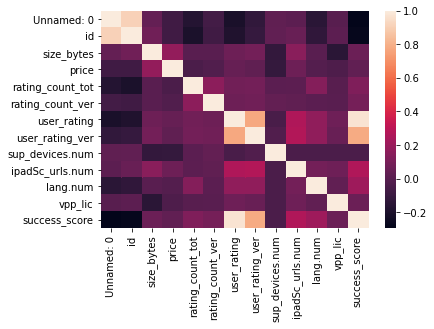

In [9]:
correlations = app_metrics.corr()
correlations
sns.heatmap(correlations)